Found 23 files.
Skipping incomplete file: P20251211070043_1a3260_responses.json
Skipping incomplete file: P20251212080537_bf826e_responses.json
Skipping incomplete file: P20251211100203_96d35b_responses.json
Skipping incomplete file: P20251210211734_7f5382_responses.json
Skipping incomplete file: P20251211113437_077c04_responses.json
Processed 18 valid files.

 ANALYSIS BY 4 CONDITIONS (Map/Text x With/Without)

--- Accuracy (%) by Condition ---


framework,with_framework,without_framework
view_type,,
map,46.296296,37.037037
text,48.148148,27.777778


/tmp/ipykernel_120204/1310238402.py:146: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=acc_plot, x='Condition', y='is_correct', palette="viridis")


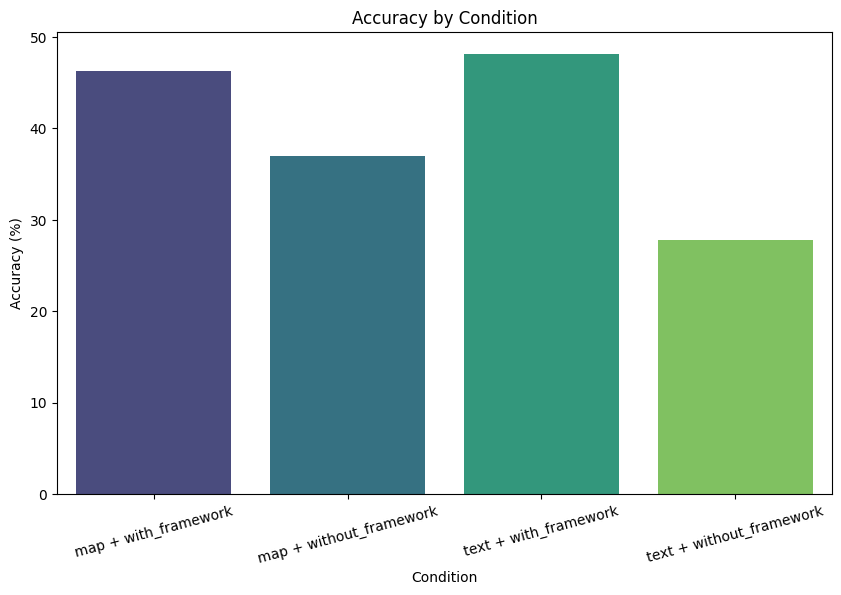


--- NASA-TLX Scores by Condition ---


mental_demand  physical_demand  temporal_demand  \
view_type framework                                                            
map       with_framework              2.89             2.44             2.89   
          without_framework           3.56             2.94             3.50   
text      with_framework              3.28             2.72             3.06   
          without_framework           4.17             3.39             3.83   

                             performance  effort  frustration  
view_type framework                                            
map       with_framework            3.50    2.94         2.44  
          without_framework         3.33    3.67         2.94  
text      with_framework            3.11    3.44         3.06  
          without_framework         3.11    4.00         3.39

/tmp/ipykernel_120204/1310238402.py:165: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melt, x='Metric', y='Score', hue='Condition', palette="Set2", ci=None)


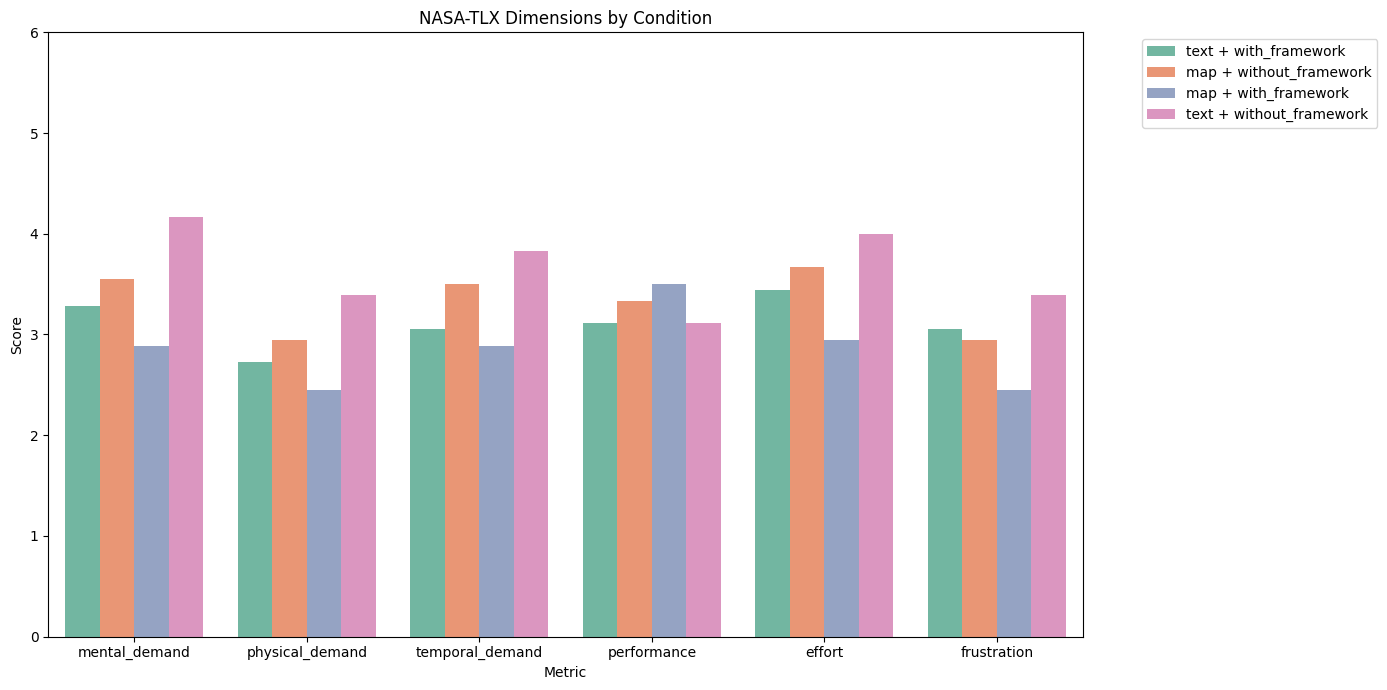


--- Overall Workload (Average of 6 metrics) ---
view_type  framework        
map        with_framework       2.85
           without_framework    3.32
text       with_framework       3.11
           without_framework    3.65
Name: Overall_Workload, dtype: float64


In [4]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ==========================================
# 1. SETUP & ANSWER KEY
# ==========================================
answer_key = {
    1: {1: "Yes", 2: "SW", 3: "Robot 3 will remain in the SW quadrant and deliver its package in the SW"},
    2: {1: {"Robot 1", "Robot 3"}, 2: "Robot 3 is encountering bad weather", 3: "Robot 2"},
    3: {1: "Replanning due to bad weather", 2: "Robot 2 will have to replan its route", 3: "Robot 2"},
    4: {1: "NE", 2: "Robot 3 discovered a package in the NE and is delivering it to the NW", 3: "NW"},
    5: {1: "Just delivered a package", 2: "Robot 2 will head towards a different package in the SW quadrant", 3: "Robot 2"},
    6: {1: {"Robot 2", "Robot 3"}, 2: "Both robots are experiencing poor weather", 3: "Robot 3 will return to the SE"}
}

def normalize(val):
    if isinstance(val, str):
        val = val.lower().strip()
        for prefix in ["a. ", "b. ", "c. ", "d. "]:
            if val.startswith(prefix): val = val[3:]
        return val
    return val

def check_answer(scenario_id, question_id, user_answer):
    correct_answer = answer_key.get(scenario_id, {}).get(question_id)
    if correct_answer is None: return False
    
    if isinstance(correct_answer, set):
        if isinstance(user_answer, list):
            return {normalize(x) for x in user_answer} == {normalize(x) for x in correct_answer}
        return False
    return normalize(user_answer) == normalize(correct_answer)

# ==========================================
# 2. DATA LOADING (ALL RUNS)
# ==========================================
tlx_data = []
accuracy_data = []

files = glob.glob('*.json')
print(f"Found {len(files)} files.")

valid_count = 0

for file_path in files:
    with open(file_path, 'r') as f:
        try:
            data = json.load(f)
        except:
            continue

    # Filter: Skip if study was not completed (missing 'post_study')
    if not any(e.get('type') == 'post_study' for e in data):
        print(f"Skipping incomplete file: {file_path}")
        continue

    valid_count += 1

    # Extract Data
    for entry in data:
        etype = entry.get('type')
        run_num = entry.get('run_number')
        
        # --- NASA-TLX ---
        if etype == 'post_scenario':
            # Create a "Condition" label for easy grouping later
            fw = entry.get('framework', 'Unknown')
            vt = entry.get('view_type', 'Unknown')
            
            answers = entry.get('answers', {})
            row = {
                'file': file_path,
                'run_number': run_num,
                'framework': fw,
                'view_type': vt,
                'Condition': f"{vt} + {fw}"  # E.g., "map + with_framework"
            }
            # Parse scores
            for metric in ['mental_demand', 'physical_demand', 'temporal_demand', 'performance', 'effort', 'frustration']:
                val = answers.get(metric)
                if val and isinstance(val, str):
                    try:
                        row[metric] = int(val.split(' - ')[0])
                    except:
                        row[metric] = None
            tlx_data.append(row)

        # --- Accuracy ---
        elif etype == 'pause_question':
            scenario = entry.get('scenario')
            q_idx = entry.get('pause_point')
            is_correct = check_answer(scenario, q_idx, entry.get('answer'))
            
            accuracy_data.append({
                'file': file_path,
                'run_number': run_num,
                'scenario': scenario,
                'question': q_idx,
                'is_correct': is_correct
            })

df_tlx = pd.DataFrame(tlx_data)
df_acc = pd.DataFrame(accuracy_data)

print(f"Processed {valid_count} valid files.")

# ==========================================
# 3. MERGE METADATA & CREATE CONDITIONS
# ==========================================
# We need to tag the Accuracy rows with the Framework/ViewType from the TLX rows
if not df_tlx.empty and not df_acc.empty:
    # Map (file, run) -> (framework, view_type, Condition)
    meta_map = df_tlx.set_index(['file', 'run_number'])[['framework', 'view_type', 'Condition']].to_dict('index')

    def get_meta(row):
        key = (row['file'], row['run_number'])
        if key in meta_map:
            return pd.Series(meta_map[key])
        return pd.Series(['Unknown', 'Unknown', 'Unknown'], index=['framework', 'view_type', 'Condition'])

    df_acc[['framework', 'view_type', 'Condition']] = df_acc.apply(get_meta, axis=1)

# ==========================================
# 4. ANALYSIS: THE 4 CONDITIONS
# ==========================================

if not df_tlx.empty:
    print("\n" + "="*50)
    print(" ANALYSIS BY 4 CONDITIONS (Map/Text x With/Without)")
    print("="*50)

    # --- A. ACCURACY TABLE ---
    if not df_acc.empty:
        print("\n--- Accuracy (%) by Condition ---")
        acc_stats = df_acc.groupby(['view_type', 'framework'])['is_correct'].mean() * 100
        display(acc_stats.unstack()) # Pivot for cleaner table

        # Plot Accuracy
        plt.figure(figsize=(10, 6))
        acc_plot = df_acc.groupby('Condition')['is_correct'].mean().reset_index()
        acc_plot['is_correct'] *= 100
        sns.barplot(data=acc_plot, x='Condition', y='is_correct', palette="viridis")
        plt.title("Accuracy by Condition")
        plt.ylabel("Accuracy (%)")
        plt.xticks(rotation=15)
        plt.show()

    # --- B. WORKLOAD (NASA-TLX) TABLE ---
    print("\n--- NASA-TLX Scores by Condition ---")
    tlx_cols = ['mental_demand', 'physical_demand', 'temporal_demand', 'performance', 'effort', 'frustration']
    
    # Group by the 4 conditions
    tlx_stats = df_tlx.groupby(['view_type', 'framework'])[tlx_cols].mean().round(2)
    display(tlx_stats)

    # Plot TLX (Heatmap style or Grouped Bar)
    # 1. Grouped Bar
    df_melt = df_tlx.melt(id_vars=['Condition'], value_vars=tlx_cols, var_name='Metric', value_name='Score')
    
    plt.figure(figsize=(14, 7))
    sns.barplot(data=df_melt, x='Metric', y='Score', hue='Condition', palette="Set2", ci=None)
    plt.title("NASA-TLX Dimensions by Condition")
    plt.ylim(0, 6) # Assuming 1-5 scale (adjust if 0-10 or 0-100)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # 2. Overall Workload (Average of all 6)
    df_tlx['Overall_Workload'] = df_tlx[tlx_cols].mean(axis=1)
    print("\n--- Overall Workload (Average of 6 metrics) ---")
    print(df_tlx.groupby(['view_type', 'framework'])['Overall_Workload'].mean().round(2))

Found 23 JSON files.
Skipping P20251211070043_1a3260_responses.json: Incomplete study (no post_study tag)
Skipping P20251212080537_bf826e_responses.json: Incomplete study (no post_study tag)
Skipping P20251211100203_96d35b_responses.json: Incomplete study (no post_study tag)
Skipping P20251210211734_7f5382_responses.json: Incomplete study (no post_study tag)
Skipping P20251211113437_077c04_responses.json: Incomplete study (no post_study tag)

Processed 18 valid complete files.

--- NASA-TLX Statistics (Mean Scores) ---


mental_demand  physical_demand  temporal_demand  \
framework         view_type                                                    
with_framework    map                 2.89             2.44             2.89   
                  text                3.28             2.72             3.06   
without_framework map                 3.56             2.94             3.50   
                  text                4.17             3.39             3.83   

                             performance  effort  frustration  
framework         view_type                                    
with_framework    map               3.50    2.94         2.44  
                  text              3.11    3.44         3.06  
without_framework map               3.33    3.67         2.94  
                  text              3.11    4.00         3.39

/tmp/ipykernel_120204/240326228.py:204: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melt, x='Metric', y='Score', hue='framework', ci=None, palette="viridis")


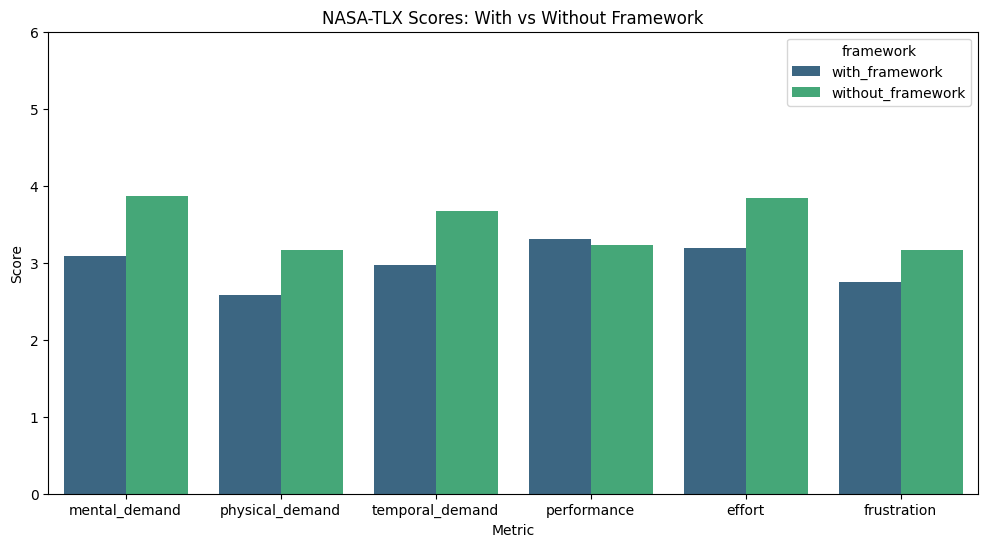

/tmp/ipykernel_120204/240326228.py:210: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melt, x='Metric', y='Score', hue='view_type', ci=None, palette="magma")


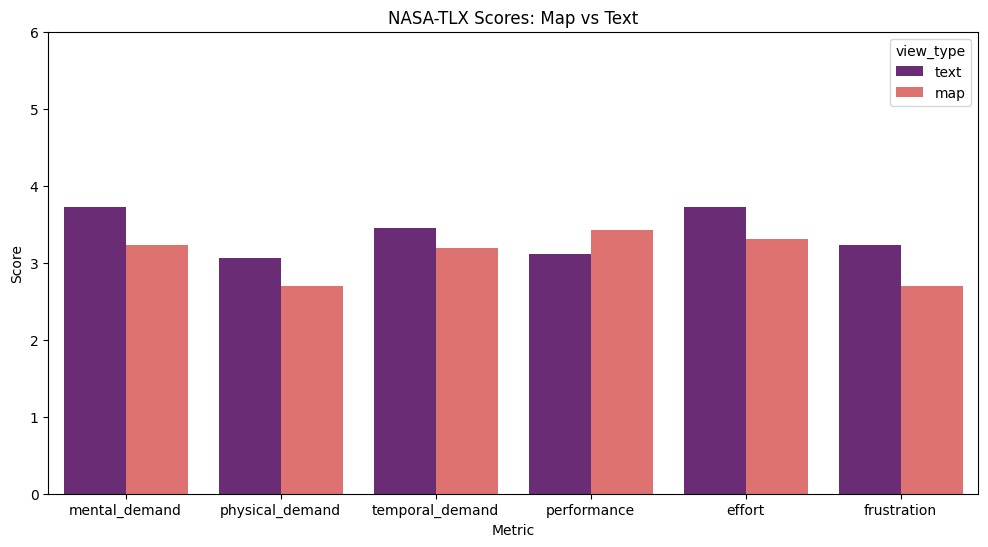


--- Accuracy Statistics ---
Overall Accuracy: 39.81%

Accuracy by Scenario (%):
scenario
1    61.111111
2    18.518519
3    42.222222
4    44.444444
5    33.333333
6    11.111111
Name: is_correct, dtype: float64

Accuracy by Framework (%):
framework
with_framework       47.222222
without_framework    32.407407
Name: is_correct, dtype: float64

Accuracy by View Type (%):
view_type
map     41.666667
text    37.962963
Name: is_correct, dtype: float64


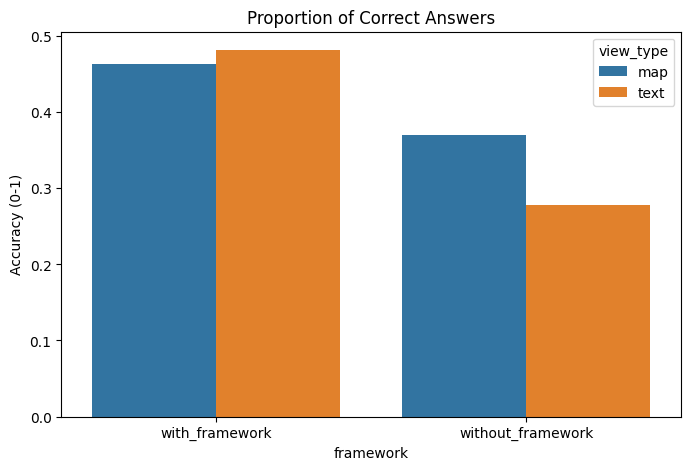

In [5]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ==========================================
# 1. SETUP & ANSWER KEY DEFINITION
# ==========================================

# Define the answer key based on your prompt
# Note: For array answers (multiple checkboxes), we use sets for comparison.
answer_key = {
    1: {
        1: "Yes",
        2: "SW",
        3: "Robot 3 will remain in the SW quadrant and deliver its package in the SW"
    },
    2: {
        1: {"Robot 1", "Robot 3"}, # Set for order-independent comparison
        2: "Robot 3 is encountering bad weather",
        3: "Robot 2"
    },
    3: {
        1: "Replanning due to bad weather",
        2: "Robot 2 will have to replan its route",
        3: "Robot 2"
    },
    4: {
        1: "NE",
        2: "Robot 3 discovered a package in the NE and is delivering it to the NW",
        3: "NW"
    },
    5: {
        1: "Just delivered a package",
        2: "Robot 2 will head towards a different package in the SW quadrant",
        3: "Robot 2"
    },
    6: {
        1: {"Robot 2", "Robot 3"},
        2: "Both robots are experiencing poor weather",
        3: "Robot 3 will return to the SE"
    }
}

# Helper to normalize answers for comparison (removes case sensitivity, extra whitespace)
def normalize(val):
    if isinstance(val, str):
        # Remove potential prefixes like "b. " if they exist in user data but not key
        val = val.lower().strip()
        if val.startswith("b. "): val = val[3:]
        if val.startswith("a. "): val = val[3:]
        if val.startswith("c. "): val = val[3:]
        if val.startswith("d. "): val = val[3:]
        return val
    return val

def check_answer(scenario_id, question_id, user_answer):
    correct_answer = answer_key.get(scenario_id, {}).get(question_id)
    
    if correct_answer is None:
        return False # No key found for this scenario/question
    
    # Handle List/Set answers (Multiple Selection)
    if isinstance(correct_answer, set):
        if isinstance(user_answer, list):
            # Normalize user list to set
            user_set = {normalize(x) for x in user_answer}
            # Normalize correct set
            correct_set = {normalize(x) for x in correct_answer}
            return user_set == correct_set
        return False

    # Handle String answers
    return normalize(user_answer) == normalize(correct_answer)


# ==========================================
# 2. DATA LOADING & FILTERING
# ==========================================

# List to store parsed data
tlx_data = []      # For NASA-TLX stats
accuracy_data = [] # For Right/Wrong counts

# Get all json files in current directory
files = glob.glob('*.json')
print(f"Found {len(files)} JSON files.")

valid_files_count = 0

for file_path in files:
    with open(file_path, 'r') as f:
        try:
            data = json.load(f)
        except json.JSONDecodeError:
            print(f"Skipping {file_path}: Invalid JSON")
            continue

    # 2a. Filter: Check for 'post_study' to ensure completion
    # We look for any entry in the list with type == 'post_study'
    is_complete = any(entry.get('type') == 'post_study' for entry in data)
    
    if not is_complete:
        print(f"Skipping {file_path}: Incomplete study (no post_study tag)")
        continue
        
    valid_files_count += 1
    
    # 2b. Process Entries
    for entry in data:
        etype = entry.get('type')
        
        # --- PROCESS NASA-TLX (Post Scenario) ---
        if etype == 'post_scenario':
            # Extract basic info
            framework = entry.get('framework')
            view_type = entry.get('view_type')
            scenario = entry.get('scenario')
            run_number = entry.get('run_number')
            
            # Parse TLX scores (Extract number from string "3 - Moderate")
            answers = entry.get('answers', {})
            row = {
                'file': file_path,
                'framework': framework,
                'view_type': view_type,
                'scenario': scenario,
                'run_number': run_number
            }
            
            for metric, value_str in answers.items():
                if value_str and isinstance(value_str, str):
                    # Take the first character and convert to int
                    try:
                        score = int(value_str.split(' - ')[0])
                        row[metric] = score
                    except:
                        row[metric] = None
            
            tlx_data.append(row)

        # --- PROCESS ACCURACY (Pause Question) ---
        elif etype == 'pause_question':
            scenario = entry.get('scenario')
            pause_point = entry.get('pause_point') # This maps to Question 1, 2, 3
            user_ans = entry.get('answer')
            framework = "Unknown" # Usually defined in post_scenario, might need lookahead/lookbehind if critical here
            # Note: The JSON structure has 'framework' in post_scenario, not pause_question. 
            # If you need to correlate accuracy with framework, we might need to map run_number to framework from the post_scenario entries.
            
            is_correct = check_answer(scenario, pause_point, user_ans)
            
            accuracy_data.append({
                'file': file_path,
                'scenario': scenario,
                'question': pause_point,
                'user_answer': user_ans,
                'is_correct': is_correct,
                'run_number': entry.get('run_number')
            })

print(f"\nProcessed {valid_files_count} valid complete files.")

# ==========================================
# 3. MERGE FRAMEWORK INFO INTO ACCURACY
# ==========================================
# Since 'pause_question' doesn't have 'framework' or 'view_type', 
# we create a mapping from (file, run_number) -> (framework, view_type) using the tlx_data
df_tlx = pd.DataFrame(tlx_data)
df_acc = pd.DataFrame(accuracy_data)

if not df_tlx.empty and not df_acc.empty:
    # Create mapping dictionary
    run_info_map = df_tlx.set_index(['file', 'run_number'])[['framework', 'view_type']].to_dict('index')

    def get_meta(row):
        key = (row['file'], row['run_number'])
        if key in run_info_map:
            return pd.Series(run_info_map[key])
        return pd.Series([None, None], index=['framework', 'view_type'])

    df_acc[['framework', 'view_type']] = df_acc.apply(get_meta, axis=1)

# ==========================================
# 4. ANALYSIS & VISUALIZATION
# ==========================================

# --- A. NASA-TLX STATS ---
if not df_tlx.empty:
    print("\n--- NASA-TLX Statistics (Mean Scores) ---")
    # Group by Framework and View Type
    tlx_cols = ['mental_demand', 'physical_demand', 'temporal_demand', 'performance', 'effort', 'frustration']
    
    grouped_tlx = df_tlx.groupby(['framework', 'view_type'])[tlx_cols].mean().round(2)
    display(grouped_tlx)

    # Plotting
    # Melt for seaborn
    df_melt = df_tlx.melt(id_vars=['framework', 'view_type'], value_vars=tlx_cols, var_name='Metric', value_name='Score')
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_melt, x='Metric', y='Score', hue='framework', ci=None, palette="viridis")
    plt.title("NASA-TLX Scores: With vs Without Framework")
    plt.ylim(0, 6) # Assuming 1-5 or 0-6 scale
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_melt, x='Metric', y='Score', hue='view_type', ci=None, palette="magma")
    plt.title("NASA-TLX Scores: Map vs Text")
    plt.ylim(0, 6)
    plt.show()

# --- B. ACCURACY STATS ---
if not df_acc.empty:
    print("\n--- Accuracy Statistics ---")
    
    # Overall % Correct
    overall_acc = df_acc['is_correct'].mean() * 100
    print(f"Overall Accuracy: {overall_acc:.2f}%")
    
    # Accuracy by Scenario
    acc_by_scenario = df_acc.groupby('scenario')['is_correct'].mean() * 100
    print("\nAccuracy by Scenario (%):")
    print(acc_by_scenario)
    
    # Accuracy by Framework/View Type
    if 'framework' in df_acc.columns:
        print("\nAccuracy by Framework (%):")
        print(df_acc.groupby('framework')['is_correct'].mean() * 100)
        
        print("\nAccuracy by View Type (%):")
        print(df_acc.groupby('view_type')['is_correct'].mean() * 100)

    # Plot Accuracy
    plt.figure(figsize=(8, 5))
    acc_plot_data = df_acc.groupby(['framework', 'view_type'])['is_correct'].mean().reset_index()
    sns.barplot(data=acc_plot_data, x='framework', y='is_correct', hue='view_type')
    plt.title("Proportion of Correct Answers")
    plt.ylabel("Accuracy (0-1)")
    plt.show()